In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

In [2]:
df = pd.read_csv('../data/processed/corses_clean.csv',index_col=False)

In [3]:
df.describe()

,viewed,explored,certified,Total_days
count,462184.000000,462184.000000,462184.000000,462184.000000
mean,0.713655,0.081442,0.038242,51.364201
std,0.452053,0.273512,0.191781,76.983585
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000
50%,1.000000,0.000000,0.000000,11.000000
75%,1.000000,0.000000,0.000000,73.000000
max,1.000000,1.000000,1.000000,409.000000


In [4]:
continent_map = {
    # América
    'United States': 'America',
    'Canada': 'America',
    'Colombia': 'America',
    'Mexico': 'America',
    'Brazil': 'America',
    'Other North & Central Amer., Caribbean': 'America',
    'Other South America': 'America',

    # Europa
    'France': 'Europe',
    'United Kingdom': 'Europe',
    'Spain': 'Europe',
    'Germany': 'Europe',
    'Portugal': 'Europe',
    'Poland': 'Europe',
    'Greece': 'Europe',
    'Ukraine': 'Europe',
    'Russian Federation': 'Europe',
    'Other Europe': 'Europe',

    # Asia
    'India': 'Asia',
    'China': 'Asia',
    'Japan': 'Asia',
    'Pakistan': 'Asia',
    'Bangladesh': 'Asia',
    'Indonesia': 'Asia',
    'Philippines': 'Asia',
    'Other East Asia': 'Asia',
    'Other South Asia': 'Asia',
    'Other Middle East/Central Asia': 'Asia',

    # África
    'Nigeria': 'Africa',
    'Egypt': 'Africa',
    'Morocco': 'Africa',
    'Other Africa': 'Africa',

    # Oceanía
    'Australia': 'Oceania',
    'Other Oceania': 'Oceania',

    # Desconocidos
    'Unknown/Other': 'Unknown'
}
df['continent'] = df['country'].map(continent_map)
df['active_engagement'] = df['active_engagement'].map({True:1,False:0})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462184 entries, 0 to 462183
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   course_id                462184 non-null  object
 1   userid_DI                462184 non-null  object
 2   viewed                   462184 non-null  int64 
 3   explored                 462184 non-null  int64 
 4   certified                462184 non-null  int64 
 5   country                  462184 non-null  object
 6   educational_achievement  462184 non-null  object
 7   gender                   462184 non-null  object
 8   start_time_DI            462184 non-null  object
 9   last_event_DI            462184 non-null  object
 10  Total_days               462184 non-null  int64 
 11  active_engagement        462184 non-null  int64 
 12  start_month              462184 non-null  object
 13  end_month                462184 non-null  object
 14  start_quarter       

In [6]:
df['start_month'] = pd.to_datetime(df['start_month'],errors='coerce')
df['start_quarter'] = pd.to_datetime(df['start_quarter'],errors='coerce')

In [7]:
df.isna().sum()

course_id                  0
userid_DI                  0
viewed                     0
explored                   0
certified                  0
country                    0
educational_achievement    0
gender                     0
start_time_DI              0
last_event_DI              0
Total_days                 0
active_engagement          0
start_month                0
end_month                  0
start_quarter              0
days_bucket                0
continent                  0
dtype: int64

In [8]:
df.columns

Index(['course_id', 'userid_DI', 'viewed', 'explored', 'certified', 'country',
       'educational_achievement', 'gender', 'start_time_DI', 'last_event_DI',
       'Total_days', 'active_engagement', 'start_month', 'end_month',
       'start_quarter', 'days_bucket', 'continent'],
      dtype='object')

In [9]:
df.drop(columns=['start_time_DI','last_event_DI','start_month',
                 'end_month','start_quarter','userid_DI',
                 'days_bucket','country','Total_days','active_engagement'],inplace=True)

In [10]:
cat_cols = df.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(drop='first',sparse_output=False)
encoded_array = encoder.fit_transform(df[cat_cols])

encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(), index=df.index)

df_encoded = pd.concat([df.drop(columns=cat_cols), encoded_df], axis=1)

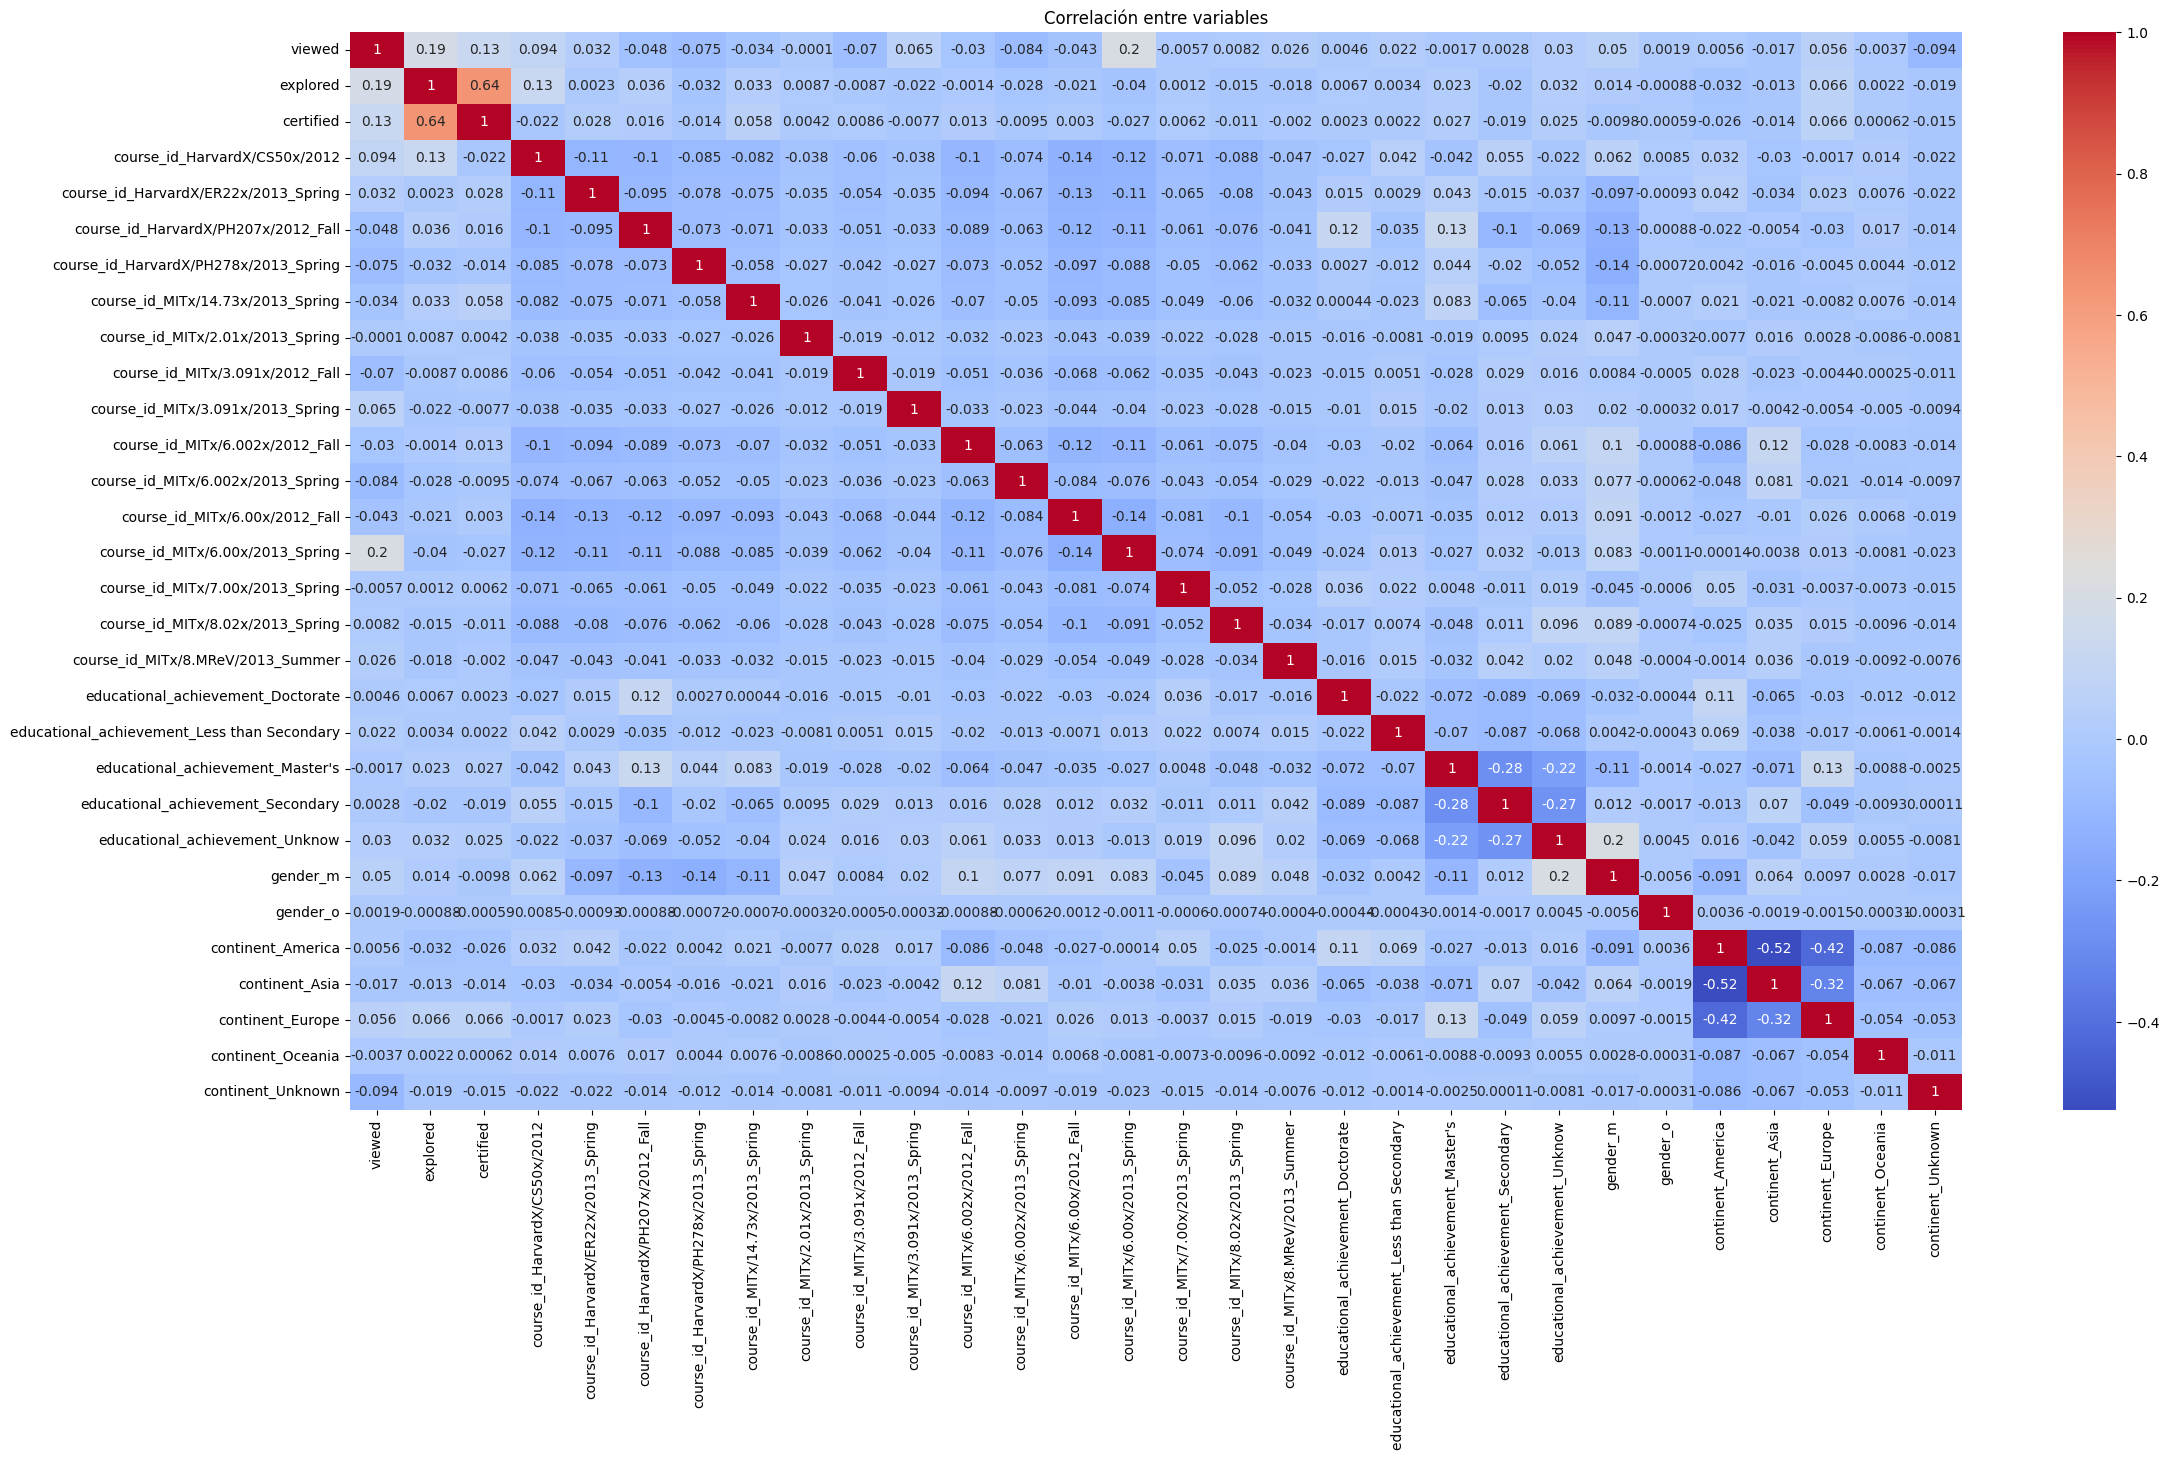

In [11]:
df_corr = df_encoded.select_dtypes(include=['int64', 'float64']).corr('spearman')
plt.figure(figsize=(26,14))
sns.heatmap(df_corr,annot=True, cmap='coolwarm')
plt.title('Correlación entre variables');

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = df_encoded.select_dtypes(include=['int64', 'float64'])
X = df_encoded.drop(columns='certified')
X = add_constant(X)

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data.sort_values(by='VIF', ascending=False).head(10)

,Variable,VIF
0,const,35.565298
25,continent_America,3.782256
26,continent_Asia,3.360858
27,continent_Europe,2.976376
13,course_id_MITx/6.00x/2012_Fall,2.846822
14,course_id_MITx/6.00x/2013_Spring,2.683848
3,course_id_HarvardX/CS50x/2012,2.571585
4,course_id_HarvardX/ER22x/2013_Spring,2.282757
11,course_id_MITx/6.002x/2012_Fall,2.235547
5,course_id_HarvardX/PH207x/2012_Fall,2.203795


### Preparación del conjunto de datos para Machine Learning

Para construir un modelo que prediga si un usuario logrará certificarse en un curso online, realizamos una preparación exhaustiva del conjunto de datos. Este proceso fue clave para garantizar que el modelo tenga una base sólida y confiable. A continuación, resumen los pasos principales:

#### Transformación de variables temporales
Las fechas originales (start_time_DI, start_month, start_quarter, etc.) no eran directamente utilizables por los modelos. Para solucionarlo:

 - Creamos variables numéricas como start_month_numy start_quarter_num, que convierten el mes y trimestre de inicio en un número secuencial. Estas variables capturan la dimensión temporal sin romper la linealidad o provocar errores de tipo.

#### Agrupación de países por continente
El conjunto de datos contenía más de 30 categorías distintas en la variable country, lo cual generaba ruido y alta cardinalidad. Para simplificar:

 - Agrupamos todos los países en 5 continentes más un grupo "Unknown" usando un mapeo. Esto redujo significativamente la dimensionalidad y mejoró la interpretabilidad del modelo.

#### Codificación de variables categóricas

 - Aplicamos One Hot Encoding a variables como: course_id, educational_achievement, gender, continent.

 - Esto convirtió las variables categóricas en columnas numéricas binarias, necesarias para entrenar este modelo de ML.

#### Revisión de multicolinealidad

 - Para asegurar que las variables independientes no estuvieran demasiado correlacionadas entre sí:

 - Calculamos el VIF (Variance Inflation Factor) para todas las variables predictoras.

 - Los resultados mostraron que no hay multicolinealidad severa. Las variables con VIF más alto (como los continentes) se mantuvieron dentro de valores aceptables.

### Resultado: Conjunto de datos limpio y listo:

-----------------------------------------------

### Modelo de Machine Learning para predecir los uusarios que se certificaran.

In [13]:
X = df_encoded.drop(columns=['certified'])
y = df_encoded['certified']

In [14]:
y.value_counts()

certified
0    444509
1     17675
Name: count, dtype: int64

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [16]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

In [24]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# rf
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1) 

# cross validation
f1_scores = cross_val_score(rf, X_train_res, y_train_res, cv=skf, scoring='f1', n_jobs=-1)

print(f"F1-score promedio en validación cruzada: {f1_scores.mean():.4f}")

rf.fit(X_train_res, y_train_res)

y_prob = rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_prob > 0.75).astype(int) 

print(classification_report(y_test,y_pred_rf))

F1-score promedio en validación cruzada: 0.9576
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     88892
           1       0.48      0.94      0.63      3545

    accuracy                           0.96     92437
   macro avg       0.74      0.95      0.81     92437
weighted avg       0.98      0.96      0.96     92437



In [18]:
xgb = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    eval_metric='auc',  # Métrica de evaluación: AUC
    use_label_encoder=False,
    random_state=42, cv=skf
)


xgb.fit(X_train_res, y_train_res)

y_prob = xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_prob > 0.95).astype(int) 

f1_scores = cross_val_score(xgb, X_train_res, y_train_res, cv=skf, scoring='f1', n_jobs=-1)

print(f"F1-score promedio en validación cruzada: {f1_scores.mean():.4f}")
# Evaluar el modelo
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

F1-score promedio en validación cruzada: 0.9124
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     88892
           1       0.43      0.96      0.59      3545

    accuracy                           0.95     92437
   macro avg       0.71      0.96      0.78     92437
weighted avg       0.98      0.95      0.96     92437



In [25]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train_res, y_train_res)

y_prob = lr.predict_proba(X_test)[:, 1]
y_pred_lr = (y_prob > 0.75).astype(int) 

f1_scores = cross_val_score(lr, X_train_res, y_train_res, cv=skf, scoring='f1', n_jobs=-1)

print(f"F1-score promedio en validación cruzada: {f1_scores.mean():.4f}")
# Evaluar el modelo
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

F1-score promedio en validación cruzada: 0.9577
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     88892
           1       0.47      0.95      0.62      3545

    accuracy                           0.96     92437
   macro avg       0.73      0.95      0.80     92437
weighted avg       0.98      0.96      0.96     92437



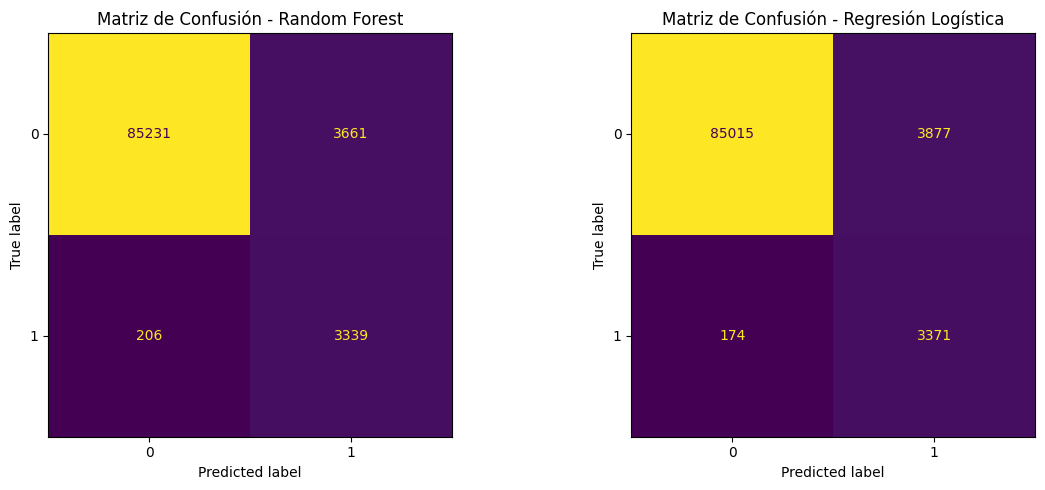

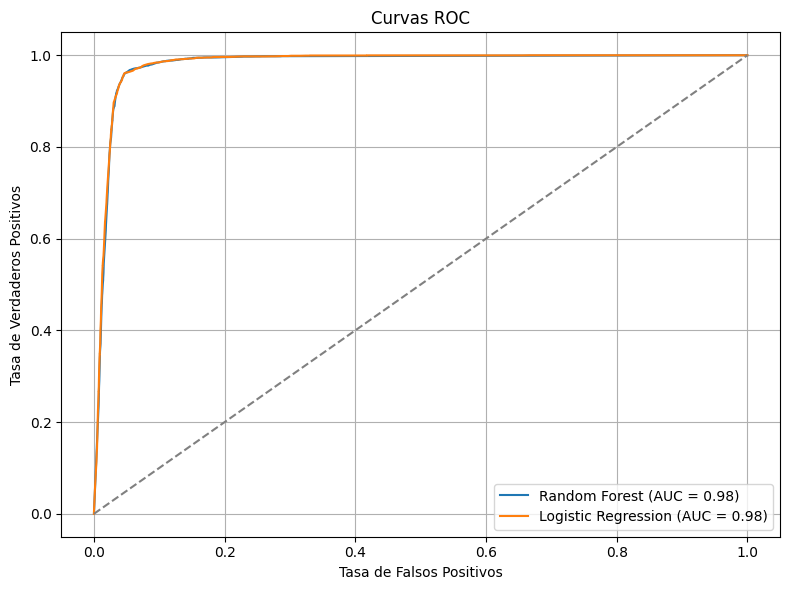

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=axes[0], colorbar=False)
axes[0].set_title('Matriz de Confusión - Random Forest')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, ax=axes[1], colorbar=False)
axes[1].set_title('Matriz de Confusión - Regresión Logística')

plt.tight_layout()
plt.show()

# ROC Curve
rf_probs = rf.predict_proba(X_test)[:, 1]
lr_probs = lr.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)

roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Aunque Random Forest obtiene una mejor precisión y un F1-score cruzado apenas superior, la Regresión Logística destaca por su mayor recall, lo que significa que identifica mejor a los usuarios que efectivamente se certifican. Además:

 - El modelo es más simple e interpretable, ideal si necesitas explicar el porqué de cada predicción.

 - Tiene un AUC ROC igual de alto (0,98) , lo que confirma su buen rendimiento general.

#### Decisión final:
 - Me quedo con Regresión Logística como modelo principal, ya que su alto retiro es clave en este contexto, donde no perder usuarios certificados es más importante que equivocarse con algunos que no lo serán.